In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm

# Read data

In [5]:
listings_file_path = '../data/airbnb/listings.csv'
al_file_path = '../data/Alojamento_Local.csv'
df_al = pd.read_csv(al_file_path)
df_listings = pd.read_csv(listings_file_path)

C:\Users\david\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# General schema

![Star schema](schema.png)

# Exploratory data analysis

In [6]:
def missing_data(df, columns):
    df_graph = df[columns]
    #missing data
    total = df_graph.isnull().sum().sort_values(ascending=False)
    percent = (df_graph.isnull().sum()/df_graph.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data)
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x='index',y = 'Percent', data= missing_data.reset_index())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    return ax

def feature_dist(df, column_name):
    plt.figure(figsize=(15,4))
    sns.distplot(df[column_name] , fit=norm)

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df[column_name])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('{} distribution'.format(column_name))
    plt.show()

#IN BAR CHARTS, SET PERCENTAGES ABOVE EACH BAR
def set_bar_percentage(ax, df):
    for p in ax.patches:
        ax.annotate(f"{p.get_height() * 100 / df.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
          ha='center', va='center', rotation=0, xytext=(0, 10),
          textcoords='offset points')
        
#IN BAR CHARTS, SET THE VALUE ABOVE EACH BAR
def set_bar_amount(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate("{0:.2f}%".format(p.get_height()*100), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', rotation=0, xytext=(0, 10),
            textcoords='offset points')
        
#Simple plot
def simple_plot(df,column):
    bx = sns.catplot(x=column,data=df, kind='count')
    (bx.set_axis_labels(column, "Count")
        .set_titles("{col_name} {col_var}")
        .despine(left=True))

## Merge df_listings with alojamento_local.csv

In [7]:
def intTryParse(value):
    """Tries to parse string to an integer"""
    try:
        a = int(value)
        return True
    except ValueError:
        return False

In [19]:
# get only listings where 
df_listings_with_license = df_listings[(~df_listings['license'].isnull()) #'license' is not null
                                        & (df_listings['license'] != 'Exempt')] # && != 'Exempt'

# string replace
df_listings_with_license['NrRNAL'] = [s.replace('/AL','').replace('.','') # remove '/AL' and '.' from code
                                      for s in df_listings_with_license['license']]

# get only records where license nr can be converted to int 
df_listings_with_license = df_listings_with_license[[intTryParse(s)
                                                     for s in df_listings_with_license['NrRNAL']]]

# convert NrRNAL to int before merge the two dataframes
df_listings_with_license['NrRNAL'] = df_listings_with_license['NrRNAL'].astype(np.int64)

# inner join two dataframes
df_result = pd.merge(df_listings_with_license, df_al, how='inner', on='NrRNAL')

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


1        56539
4        23535
5        28737
6        55695
7        85851
         ...  
24995    59854
24997    61018
24998    84760
25000    43084
25001    61018
Name: NrRNAL, Length: 19776, dtype: object


In [7]:
print('Dataset size: {}'.format(len(df_result)))

dataset size: 17168


## Missing data

                    Total   Percent
host_response_time   1691  0.098497
host_location          21  0.001223
host_verifications      0  0.000000
host_is_superhost       0  0.000000
host_since              0  0.000000
host_name               0  0.000000


Text(0.5, 1.0, 'Host dimension missing values')

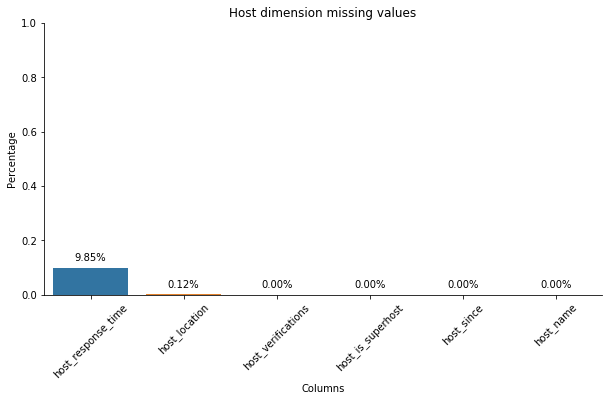

In [20]:
columns = [
'host_name',
'host_since',
'host_location',
'host_response_time',
'host_is_superhost',
'host_verifications'
]
ax = missing_data(df_result,columns)
set_bar_amount(ax)
ax.set_xlabel('Columns')
ax.set_ylabel('Percentage')
plt.ylim(0,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Host dimension missing values')

## Host dimension

**host_name**

varchar(40), no missing data

In [12]:
print(df_result['host_name'])

0                  Ellie
1                Bárbara
2                 Mónica
3              Francisco
4              Francisco
              ...       
17163    Feels Like Home
17164             Raquel
17165             Raquel
17166             Simone
17167              Fábio
Name: host_name, Length: 17168, dtype: object


**host_since**

date AAAA-MM-DD

In [14]:
df_result['host_since']

0        2010-04-12
1        2010-05-16
2        2010-05-17
3        2010-05-19
4        2010-05-19
            ...    
17163    2012-10-23
17164    2012-05-31
17165    2012-05-31
17166    2019-12-07
17167    2016-01-17
Name: host_since, Length: 17168, dtype: object

**host_country**

-- Need to extract countries

Attention -- 21 missing values - probably delete rows

In [24]:
print(df_result['host_location'].value_counts())

Lisbon, Lisbon, Portugal         9020
PT                               2845
Portugal                          744
Cascais, Lisbon, Portugal         584
Sintra, Lisbon, Portugal          311
                                 ... 
Rio Maior, Santarém, Portugal       1
Copenhagen, Denmark                 1
Dallas, Texas, United States        1
Santa Cruz, Madeira, Portugal       1
Portugal, Moçambique e India        1
Name: host_location, Length: 618, dtype: int64


**host_country_gdp**

-- Need to fetch this data

**host_continent**

-- Need to fetch this data

**host_response_time**

{'within an hour','within a few hours','within a day','a few days or more'}

Attention -- 1691 missing values - delete rows or replace with 'unkwown'

In [18]:
print(df_result['host_response_time'].value_counts())

within an hour        12943
within a few hours     1506
within a day            884
a few days or more      144
Name: host_response_time, dtype: int64


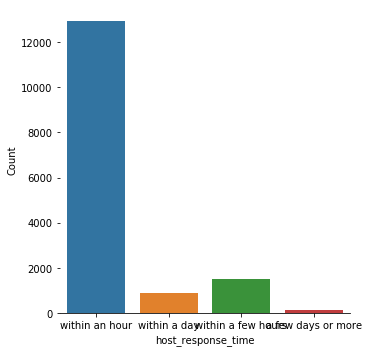

In [19]:
simple_plot(df_result, 'host_response_time')

**host_is_superhost**

--Change to "Superhost" and "Not Superhost"

In [26]:
print(df_result['host_is_superhost'].value_counts())

f    11879
t     5289
Name: host_is_superhost, dtype: int64


**host_identity_verified**

-- Change to "Verified" and "Not Verified"

In [27]:
print(df_result['host_identity_verified'].value_counts())

f    12200
t     4968
Name: host_identity_verified, dtype: int64
